In [1]:
import torch
import numpy as np
import ifbo
from ifbo import Curve, PredictionResult

In [3]:
# if necessary
# !pip install matplotlib

In [4]:
from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Getting Started with ifBO

This notebook provides an introduction to using FT-PFN. FT-PFN is the surrogate model used in ifBO. FT-PFN allows efficient prediction of the learning curve of a configuration and can be integrated into any multi-fidelity Bayesian optimization loop.

In [5]:
model = ifbo.surrogate.FTPFN(version="0.0.1", device=device)

/work/dlclarge1/mallik-lcpfn-hpo/misc/herilalaina/ifbomain/ifbo/surrogate.py:70: UserWarning: No target path provided. Defaulting to current working directory: /work/dlclarge1/mallik-lcpfn-hpo/misc/herilalaina/ifbomain/examples.
Please provide the above path or any other valid path to avoid this warning.
  warnings.warn(


Each curve is represented by the `ifbo.Curve` class, which stores the hyperparameter values of the configuration and its performance over time. Both the observed and unseen parts of the curves can be represented using the same class. A set of observed and unseen curves can be constructed as follows:
- `context`: Data points where both time (`t`) and observed performance values (`y`) are known.
- `query`: Data points where only time (`t`) is known, and predictions for performance (`y`) are needed.

In [6]:
context = [
    Curve(hyperparameters=torch.tensor([0.2,0.1,0.5]), t=torch.tensor([0.1,0.2,0.3]), y=torch.tensor([0.1, 0.15, 0.3])),
    Curve(hyperparameters=torch.tensor([0.2,0.3,0.25]), t=torch.tensor([0.1,0.2,0.3,0.4]), y=torch.tensor([0.2, 0.5, 0.6, 0.75])),
]

query = [
    Curve(hyperparameters=torch.tensor([0.2, 0.1, 0.5]), t=torch.tensor([0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1])),
    Curve(hyperparameters=torch.tensor([0.2, 0.3, 0.25]), t=torch.tensor([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])),
    Curve(hyperparameters=torch.tensor([0.8, 0.2, 0.6]), t=torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1])),
]

FT-PFN predicts a set of unseen curves, given the context curves, in a single forward pass.

In [7]:
predictions: list[PredictionResult] = model.predict(context=context, query=query)

The output of `predict` is a list of `PredictionResult` objects, each containing the result of a curve in `query`. The `PredictionResult` class aims to ease the computation of common statistics and quantities (e.g. quantile, EI, PI or UCB) from the predicted posterior distribution. 

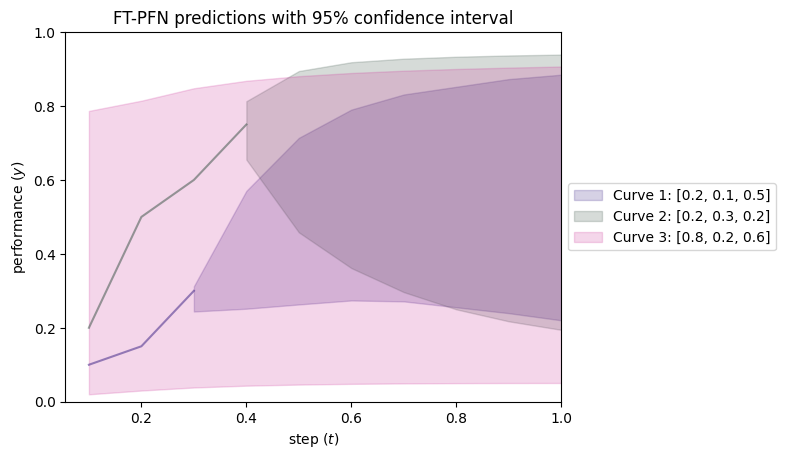

In [8]:
for curve in context:
    plt.plot(curve.t, curve.y, color=curve.hyperparameters.numpy().tolist() + [0.5])

for i, (curve, pred) in enumerate(zip(query, predictions)):
    c = curve.hyperparameters.numpy().tolist() + [0.2]
    y025, y975 = pred.quantile(0.025).cpu(), pred.quantile(0.975).cpu()
    label = f"Curve {i+1}: " + str([round(_, 1) for _ in curve.hyperparameters.numpy().tolist()])
    torch.round(curve.hyperparameters, decimals=1).tolist()
    plt.fill_between(curve.t, y025, y975, color=c, label=label)
_ = plt.ylim(0, 1), plt.xlim(None, 1)
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="")
_ = plt.xlabel("step ($t$)")
_ = plt.ylabel("performance ($y$)")
_ = plt.title("FT-PFN predictions with 95% confidence interval")

**Please note that FT-PFN can provide predictions for curve 3 without having observed points on the same curve, using solely information from the other curves.**

# FT-PFN Curve Prior

FT-PFN is trained on synthetic curves generated from a predefined prior. As described in section 4.2 of the main paper, our prior models the interaction between hyperparameter values and their learning curves. For illustration purposes, the code below samples and plots 50 configurations (in three dimensions) along with their respective learning curves. Curves are colored according to the hyperparameter values (i.e., similar hyperparameters have similar colors).

In [53]:
hyperparameters, curves = ifbo.priors.ftpfn_prior.sample_curves(num_hyperparameters=50, hyperparameter_dimensions=3, curve_length=100)

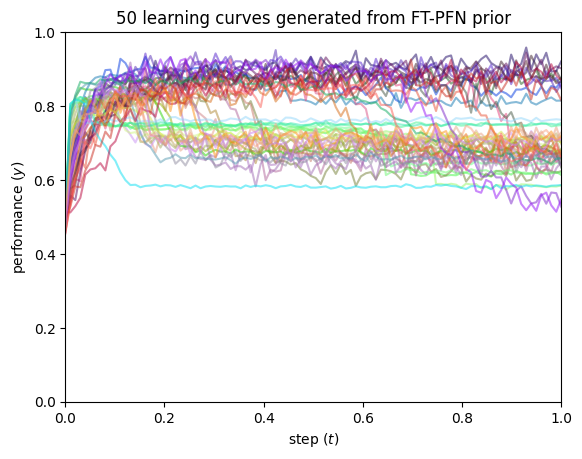

In [54]:
for hp, curve in zip(hyperparameters, curves):
    plt.plot(np.linspace(0, 1, curve.shape[0]), curve, color=hp.tolist() + [0.5])
plt.xlim(0, 1)
plt.ylim(0, 1)
_ = plt.xlabel("step ($t$)")
_ = plt.ylabel("performance ($y$)")
_ = plt.title("50 learning curves generated from FT-PFN prior")

Another important aspect of training is how we construct `context` and `target` points from the generated synthetic curves. The subsampling strategy is explained in detail in the paper; see Appendix A.2. Here, we provide a high-level overview of how this is constructed, given `single_eval_pos` (number of observations).

In [57]:
single_eval_pos = 700 # number of observations in the context (< seq_len).
batch = ifbo.priors.ftpfn_prior.get_batch(
    batch_size=1,
    seq_len=1000, # maximum number of observations per task for training. Default: 1000.
    num_features=12, # sample the dimension of HPs with Uniform(1, num_features-1). Default: 12.
    single_eval_pos=single_eval_pos 
)
context, query = ifbo.utils.detokenize(batch, context_size=single_eval_pos, device=device)

The above `context` and `query` correspond to a list of `Curve` objects. Similar to the above plots, we can plot the context and query points of each curve, using the hyperparameter values to identify the curve. Points having similar values thus correspond to the same curve (configuration) but evaluated at different steps.

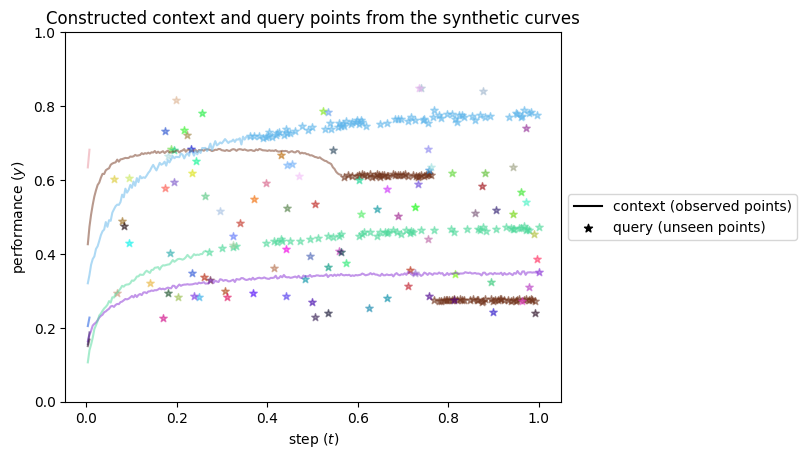

In [58]:
for curve in context:
    plt.plot(curve.t.cpu(), curve.y.cpu(), color=curve.hyperparameters[:3].cpu().numpy().tolist() + [0.5])
for curve in query:
    plt.scatter(curve.t.cpu(), curve.y.cpu(), color=curve.hyperparameters[:3].cpu().numpy().tolist() + [0.5], s=32, marker="*")
_ = plt.ylim(0, 1)

plt.plot([], [], color='black', label='context (observed points)')
plt.scatter([], [], color='black', marker='*', linestyle='None', label='query (unseen points)')
_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = plt.xlabel("step ($t$)")
_ = plt.ylabel("performance ($y$)")
_ = plt.title("Constructed context and query points from the synthetic curves")